In [2]:
%load_ext autoreload
%autoreload 2

# Trabajo Práctico 4: Aprendizaje No-Supervisado

### 1. Clustering de datos. Para el dataset clustering.csv realizar los siguientes análisis:

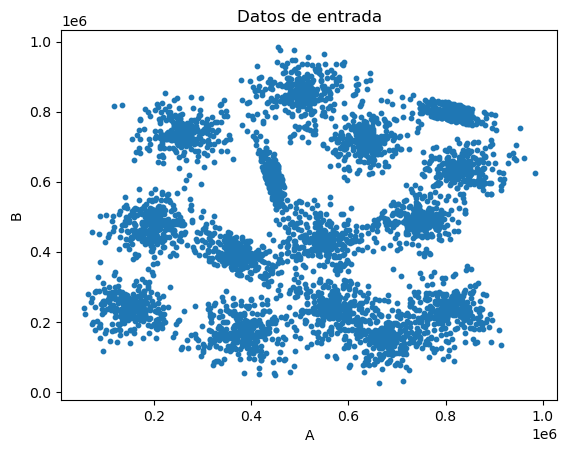

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.algorithms import kmeans, gmm, dbscan, pca

df = pd.read_csv('data/clustering.csv')
X = df[['A', 'B']].values

# graficar los datos
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('Datos de entrada')
plt.xlabel('A')
plt.ylabel('B')
plt.show()

# normalizar los datos
X = (X - X.mean(axis=0)) / X.std(axis=0)



Implementar el algoritmo K-means y determinar la cantidad de clusters con el método de “ganancias decrecientes” (graficar L vs. K, y elegir un valor K donde al aumentar K deje de reducir significativamente L, donde L es la suma de las distancias). Graficar el conjunto de datos xi mostrando a qué cluster pertenece cada dato (usando colores/marcadores distintos para cada cluster) y también mostrar el centroide de cada cluster.

Primero graficamos L vs K

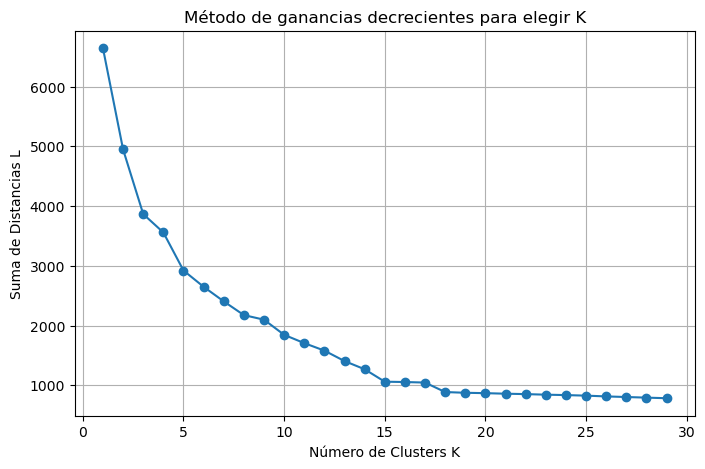

In [36]:
Ks = range(1, 30)
Ls = []

for k in Ks:
    _, _, L = kmeans(X, k)
    Ls.append(L)

# Graficar L vs. K
plt.figure(figsize=(8, 5))
plt.plot(Ks, Ls, marker='o')
plt.xlabel('Número de Clusters K')
plt.ylabel('Suma de Distancias L')
plt.title('Método de ganancias decrecientes para elegir K')
plt.grid(True)
plt.show()

Mirando el grafico elegimos K = 9 y graficamos clusters

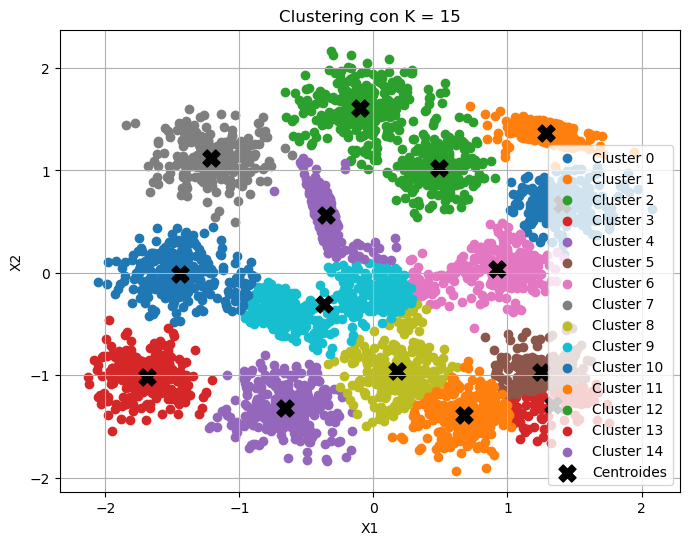

In [37]:
K_optimo = 15
labels, centroids, _ = kmeans(X, K_optimo)

# Graficar clusters y centroides
plt.figure(figsize=(8, 6))
for k in range(K_optimo):
    cluster_points = X[labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=150, marker='X', label='Centroides')
plt.title(f'Clustering con K = {K_optimo}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()

Implementar el algoritmo Gaussian Mixture Model (GMM) y realizar la misma tarea que en el inciso anterior. Recuerde que puede inicializar la optimización de GMM con una corrida de K-means.

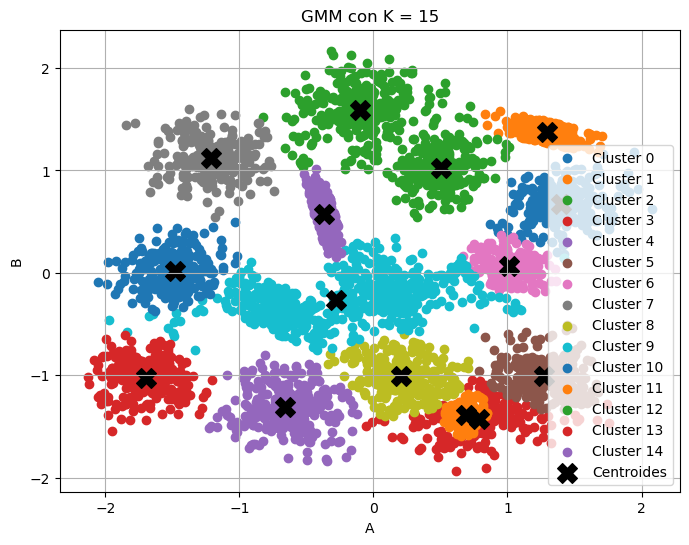

In [38]:
K_opt = 15
labels, means, _ = gmm(X, K_opt)

plt.figure(figsize=(8, 6))
for i in range(K_opt):
    points = X[labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")
plt.scatter(means[:, 0], means[:, 1], color='black', marker='X', s=200, label='Centroides')
plt.title(f"GMM con K = {K_opt}")
plt.xlabel("A")
plt.ylabel("B")
plt.legend()
plt.grid(True)
plt.show()


Implementar el algoritmo DBSCAN y aplicarlo al conjunto de datos. Explorar el efecto de variar los parámetros ε (radio de la vecindad) y K (mínimo número de puntos en una zona densa). Luego, elegir una combinación razonable de ε y K y graficar los datos
mostrando a qué cluster pertenece cada uno, utilizando colores/marcadores distintos para cada cluster/ruido.

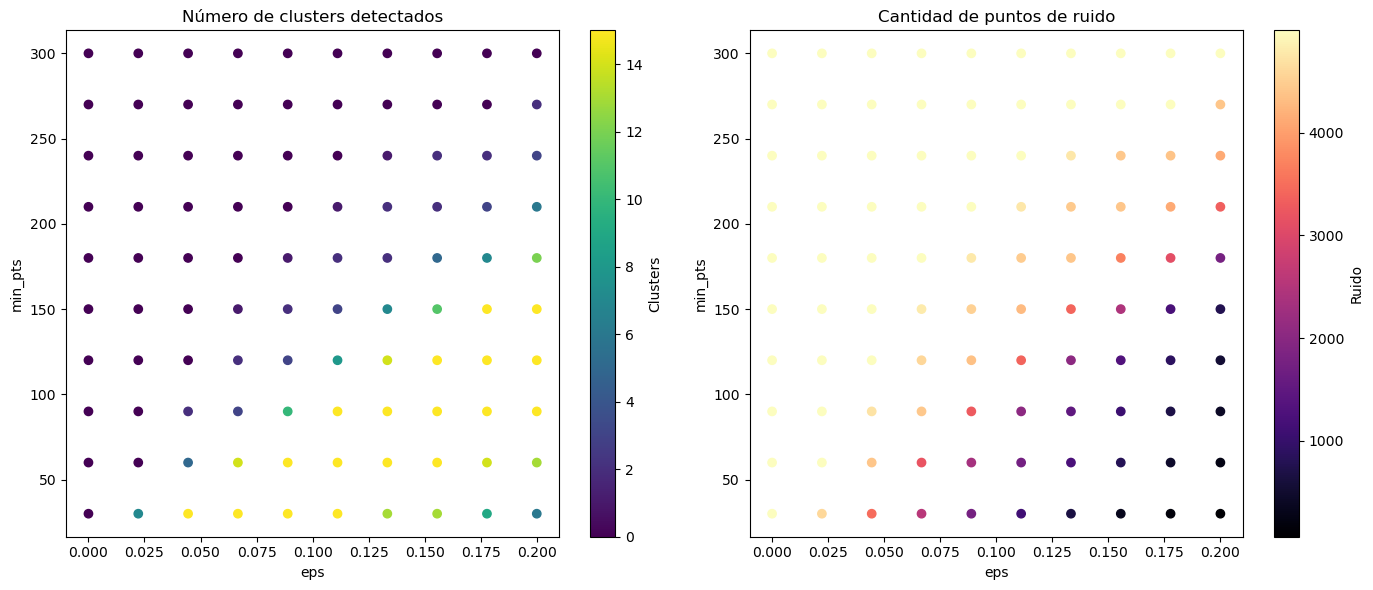

In [39]:
eps_l = np.linspace(0, 0.2, 10)
min_pts_l = np.linspace(30,300, 10)

results = []
for eps in eps_l:
    for min_pts in min_pts_l:
        labels = dbscan(X, eps=eps, min_pts=min_pts)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        results.append((eps, min_pts, n_clusters, n_noise))

results = np.array(results)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de número de clusters
sc1 = ax[0].scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='viridis')
ax[0].set_xlabel('eps')
ax[0].set_ylabel('min_pts')
ax[0].set_title('Número de clusters detectados')
fig.colorbar(sc1, ax=ax[0], label='Clusters')

# Gráfico de cantidad de ruido
sc2 = ax[1].scatter(results[:, 0], results[:, 1], c=results[:, 3], cmap='magma')
ax[1].set_xlabel('eps')
ax[1].set_ylabel('min_pts')
ax[1].set_title('Cantidad de puntos de ruido')
fig.colorbar(sc2, ax=ax[1], label='Ruido')

plt.tight_layout()
plt.show()

vemos que con bajo ε y alto K, hay muy pocos clusters. tambien vemos que con mucho K, tiene mucho ruido, aunque cuanto mas ε menos ruido.

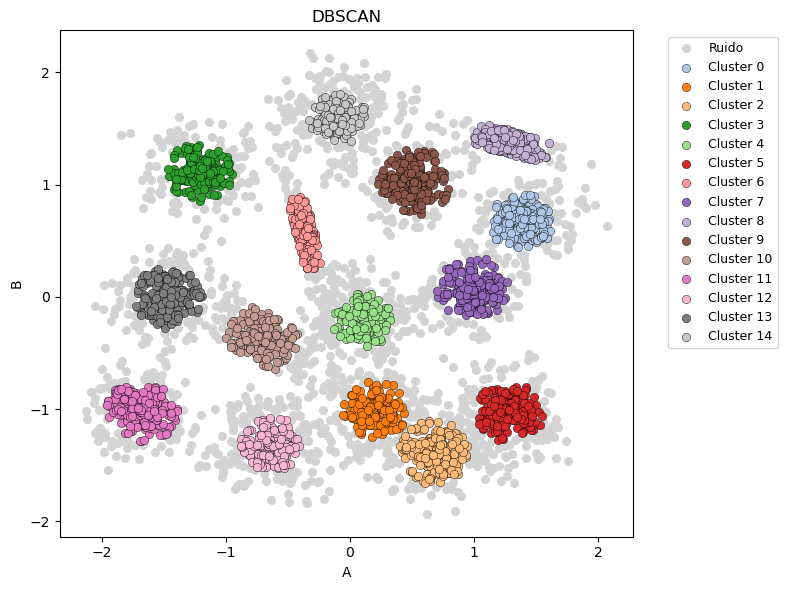

In [41]:
def plot_dbscan(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    colors = plt.colormaps.get_cmap("tab20")

    plt.figure(figsize=(8, 6))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            # Ruido: color gris claro, transparente
            plt.scatter(
                X[mask, 0], X[mask, 1],
                c='lightgray',
                alpha=1,
                s=30,
                label="Ruido"
            )
        else:
            plt.scatter(
                X[mask, 0], X[mask, 1],
                color=colors(i % 20),
                label=f"Cluster {label}",
                edgecolor='k',
                linewidth=0.3
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.title("DBSCAN")
    plt.xlabel("A")
    plt.ylabel("B")
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con parámetros elegidos
labels = dbscan(X, eps=0.16, min_pts=125)
plot_dbscan(X, labels)


Reducción de dimensionalidad. Este problema se basará en el dataset MNIST_dataset.csv, que contiene representaciones tabulares de imágenes de dígitos del 0 al 9. Originalmente, cada imagen tiene una resolución de 28x28 píxeles en escala de grises. En este conjunto de datos, cada imagen se representa como una fila de 784 (28x28) valores, donde cada valor representa la intensidad de gris de un píxel en la imagen.

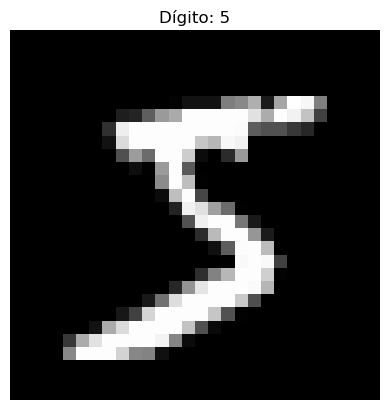

In [76]:
df = pd.read_csv("data/MNIST_dataset.csv")
X = df.drop(columns=["label"]).values
y = df["label"].values

X = X/255

# Mostrar una imagen
idx = 0
plt.imshow(X[idx].reshape(28, 28), cmap="gray")
plt.title(f"Dígito: {y[idx]}")
plt.axis("off")
plt.show()

Implementar Principal Component Analysis (PCA) y aplicarlo al conjunto de datos. Graficar cómo varía el error cuadrático medio de reconstrucción sobre el conjunto de datos en función de la cantidad de componentes principales utilizadas.

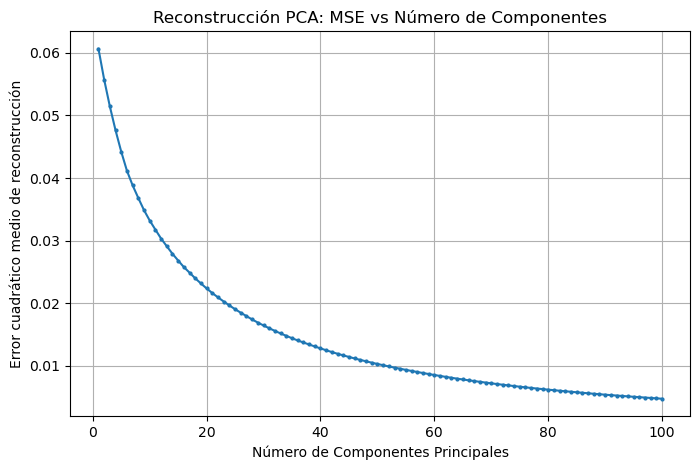

In [54]:
mse_list = []
components_range = range(1, 101)
for n in components_range:
    _, X_recon, _ = pca(X, n_components=n)
    mse = np.mean((X - X_recon) ** 2)
    mse_list.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(components_range, mse_list, marker='o', markersize=2)
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Error cuadrático medio de reconstrucción")
plt.title("Reconstrucción PCA: MSE vs Número de Componentes")
plt.grid(True)
plt.show()

Seleccionar la cantidad de componentes principales que considere adecuada y justifique la elección. Usando dicha cantidad de componentes, graficar las imagenes de los digitos originales y reconstruidos para las primeras 10 muestras del dataset.

Componentes para 90% varianza explicada: 87
Componentes para 75% varianza explicada: 33
Componentes para 50% varianza explicada: 11


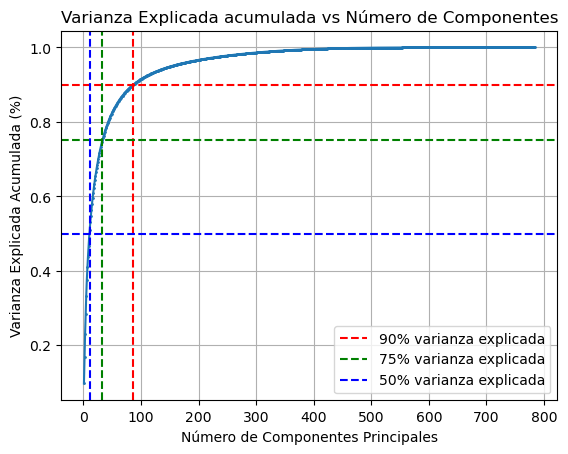

In [55]:
import tqdm
_, _, eigvals_sorted = pca(X, n_components=X.shape[1])

# Calcular varianza explicada acumulada
total_variance = np.sum(eigvals_sorted)
explained_variance_ratio = np.cumsum(eigvals_sorted) / total_variance

# Convertir a porcentaje
explained_variance_ratio_percent = explained_variance_ratio
components_list = list(range(1, len(eigvals_sorted) + 1))

idx_90 = np.argmax(explained_variance_ratio_percent >= 0.90)
idx_75 = np.argmax(explained_variance_ratio_percent >= 0.75)
idx_50 = np.argmax(explained_variance_ratio_percent >= 0.50)

# Graficar
plt.plot(components_list, explained_variance_ratio_percent, marker='o', markersize=1)
plt.axvline(x=components_list[idx_90], color='r', linestyle='--', label='90% varianza explicada')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.axhline(y=0.75, color='g', linestyle='--')
plt.axhline(y=0.50, color='b', linestyle='--')
print(f"Componentes para 90% varianza explicada: {components_list[idx_90]}")
print(f"Componentes para 75% varianza explicada: {components_list[idx_75]}")
print(f"Componentes para 50% varianza explicada: {components_list[idx_50]}")
plt.axvline(x=components_list[idx_75], color='g', linestyle='--', label='75% varianza explicada')
plt.axvline(x=components_list[idx_50], color='b', linestyle='--', label='50% varianza explicada')

plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada (%)")
plt.title("Varianza Explicada acumulada vs Número de Componentes")
plt.legend()
plt.grid(True)
plt.show()

Entonces nos quedamos con 87 componentes como el optimo con 90% 

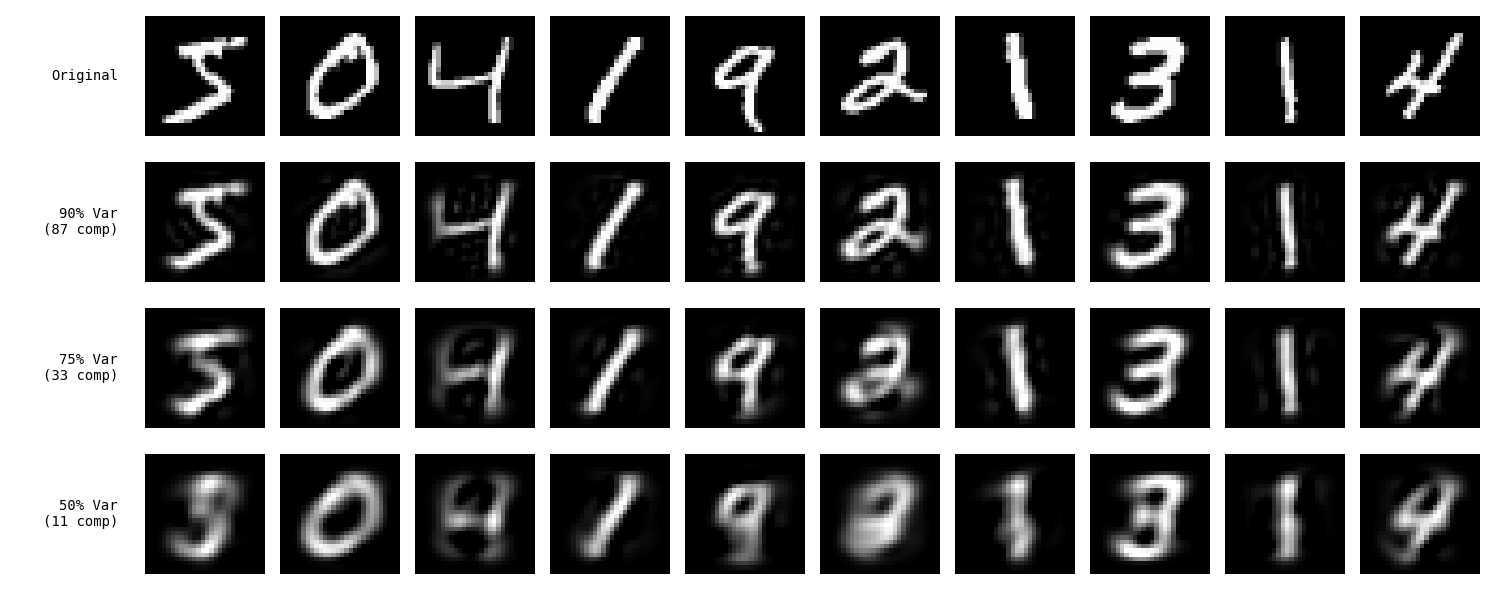

In [38]:


# Reconstrucción con diferentes cantidades de componentes principales
n_components_90 = 87   # 90% varianza explicada
n_components_75 = 33   # 75% varianza explicada
n_components_50 = 11   # 50% varianza explicada

# Reconstrucciones
_, X_recon_90, _ = pca(X, n_components=n_components_90)
_, X_recon_75, _ = pca(X, n_components=n_components_75)
_, X_recon_50, _ = pca(X, n_components=n_components_50)

# Crear figura con una columna extra para los textos
fig, axes = plt.subplots(4, 11, figsize=(15, 6))  # 10 imágenes + 1 para los títulos
labels = [
    "Original",
    f"90% Var\n({n_components_90} comp)",
    f"75% Var\n({n_components_75} comp)",
    f"50% Var\n({n_components_50} comp)",
]

for row in range(4):
    for col in range(11):
        ax = axes[row, col]
        ax.axis("off")
        
        if col == 0:
            # Etiqueta de fila en la columna extra
            ax.text(0.9, 0.5, labels[row], ha="right", va="center", fontsize=10, transform=ax.transAxes, family="monospace")
        else:
            i = col - 1
            if row == 0:
                img = X[i]
            elif row == 1:
                img = X_recon_90[i]
            elif row == 2:
                img = X_recon_75[i]
            elif row == 3:
                img = X_recon_50[i]

            ax.imshow(img.reshape(28, 28), cmap="gray")

plt.tight_layout()
plt.show()


In [82]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.pytorch import VAE, loss_function

df = pd.read_csv("data/MNIST_dataset.csv")
X = df.drop(columns=["label"]).values
y = df["label"].values

X = X/255

X_tensor = torch.tensor(X, dtype=torch.float32)
# X_tensor /= 255.0

dataset = TensorDataset(X_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)


Entrenar un modelo de autoencoder variacional (VAE) utilizando la librería PyTorch para armar y entrenar las redes neuronales involucradas (la red de encoder y la de decoder). Recuerde dividir el conjunto de datos en dos subconjuntos: entrenamiento y validación. El subconjunto de entrenamiento se empleará para entrenar el VAE, mientras que el de validación servirá para ajustar los hiperparámetros y evaluar el error de reconstrucción.

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Entrenamiento
epochs = 20
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(x_batch)
        loss = loss_function(recon_batch, x_batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.2f}")


Epoch 1, Loss: 46.37
Epoch 2, Loss: 35.60
Epoch 3, Loss: 33.50
Epoch 4, Loss: 32.48
Epoch 5, Loss: 31.91
Epoch 6, Loss: 31.58
Epoch 7, Loss: 31.31
Epoch 8, Loss: 31.10
Epoch 9, Loss: 30.94
Epoch 10, Loss: 30.80
Epoch 11, Loss: 30.65
Epoch 12, Loss: 30.55
Epoch 13, Loss: 30.48
Epoch 14, Loss: 30.38
Epoch 15, Loss: 30.30
Epoch 16, Loss: 30.23
Epoch 17, Loss: 30.15
Epoch 18, Loss: 30.06
Epoch 19, Loss: 30.02
Epoch 20, Loss: 29.94


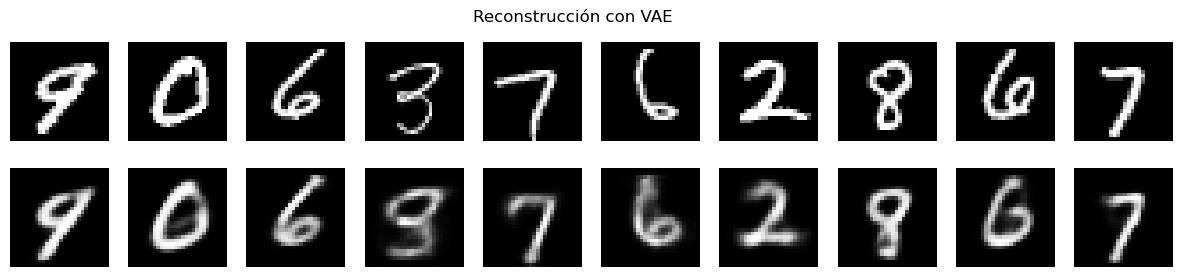

In [80]:
vae.eval()
with torch.no_grad():
    x_val = next(iter(val_loader))[0].to(device)[:10]  # 10 imágenes
    recon_val, _, _ = vae(x_val)

# Visualizar originales vs reconstruidas
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(x_val[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_val[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel("Originales")
axes[1, 0].set_ylabel("Reconstruidas")
plt.suptitle("Reconstrucción con VAE")
plt.show()


 Una vez desarrollado el VAE, compare la calidad de las imágenes reconstruidas con las obtenidas mediante PCA en el inciso anterior, utilizando 10 imagenes tomadas aleatoriamente del conjunto de validación del VAE.

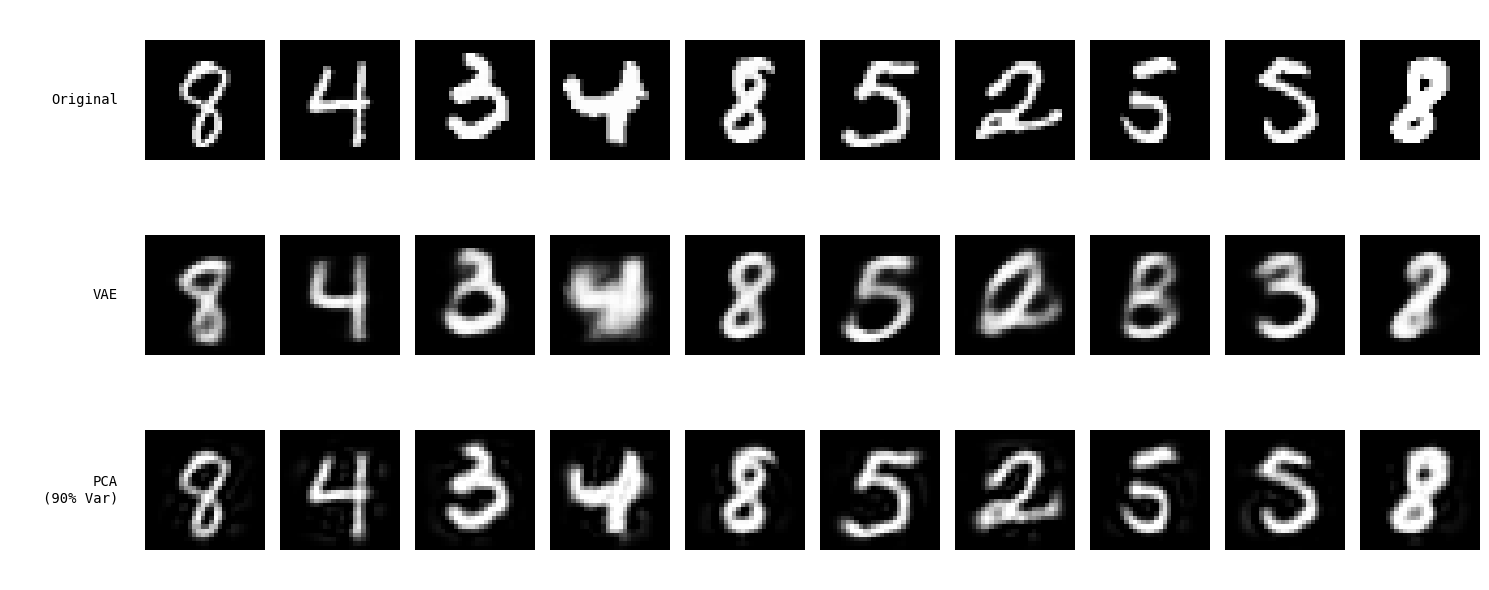

In [ ]:
# Obtener todo el set de validación
all_val_data = torch.cat([batch[0] for batch in val_loader], dim=0)
X_val = all_val_data.cpu().numpy().reshape(len(all_val_data), -1)

# Aplicar PCA sobre todo el val
_, _, eigvals_sorted, W, X_mean = pca(X_val, n_components=87)

# Elegís 10 imágenes del val aleatoriamente
idxs = torch.randperm(len(all_val_data))[:10]
x_val = all_val_data[idxs].to(device)

# Reconstrucción con VAE
with torch.no_grad():
    recon_val, _, _ = vae(x_val)

# Proyectar y reconstruir con los componentes ya calculados (PCA)
X_10 = x_val.cpu().numpy().reshape(10, -1)
X_10_centered = X_10 - X_mean
X_proj = X_10_centered @ W
X_recon_90 = X_proj @ W.T + X_mean
X_recon_90 = np.clip(X_recon_90, 0, 1)

# Visualización
fig, axes = plt.subplots(3, 11, figsize=(15, 6))
labels = [
    "Original",
    f"VAE",
    f"PCA\n(90% Var)",
]

for row in range(3):
    for col in range(11):
        ax = axes[row, col]
        ax.axis("off")
        
        if col == 0:
            ax.text(0.9, 0.5, labels[row], ha="right", va="center", fontsize=10, transform=ax.transAxes, family="monospace")
        else:
            i = col - 1
            if row == 0:
                img = x_val[i].cpu().numpy()
            elif row == 1:
                img = recon_val[i].cpu().numpy()
            elif row == 2:
                img = X_recon_90[i]

            ax.imshow(img.reshape(28, 28), cmap="gray")

plt.tight_layout()
plt.show()
